<a href="https://colab.research.google.com/github/mscholl96/mad-recime/blob/network_CVAE/network/CVAE/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/ingredients_complete.pkl'
embeddingPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/vocab.bin'
unitDictPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/ingredients_unitDict.pkl'
modelOutPath = "/content/drive/MyDrive/TP2/Network/VAE/vae.pt"
import sys
sys.path.append(dataPath)

In [ ]:
dataPath = 'data/ingredients_complete_2k.pkl'
embeddingPath = 'data/vocab.bin'
unitDictPath = 'data/ingredients_unitDict.pkl'

In [3]:
import pickle
import pandas as pd

with open(dataPath, 'rb') as f:
    pklData = pickle.load(f)

print(pklData.keys())
print(len(pklData))

Index(['000033e39b', '000035f7ed', '00003a70b1', '00004320bb', '0000631d90',
       '000075604a', '00007bfd16', '000095fc1d', '0000973574', '0000b1e2b5',
       ...
       'ffff606358', 'ffff70ccee', 'ffff728423', 'ffff72b421', 'ffff7f3e9f',
       'ffff89d1ae', 'ffffbb45d2', 'ffffcd4444', 'ffffd533d7', 'ffffdea29a'],
      dtype='object', name='id', length=834840)
834840


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [4]:
!pip install word2vec

In [5]:
from src.ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor(embeddingPath, unitDictPath)
#pklData = pklData[:2000]
#processedInput = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [6]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import custom autoencoder
from src.ReciMeEncoder import ReciMeEncoder

# Import custom helper functions
from src.networkUtils import CustomLoss, DataBuilder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Setup Datasets + Hyperparameters

In [7]:
# One hot encoding without embedding and using sparse frame
train_data, test_data =  train_test_split(pklData, test_size=0.3, random_state=42)
batch_size = 2048
# Definition of batches
train_builder = DataBuilder(train_data, preprocessor)
test_builder = DataBuilder(test_data, preprocessor)

trainloader=DataLoader(dataset=train_builder, batch_size=batch_size, collate_fn=train_builder.customCollate)
testloader=DataLoader(dataset=test_builder, batch_size=batch_size, collate_fn=test_builder.customCollate)

In [8]:
paramList = [train_builder.customCollate([train_builder[0]]).shape[1], 12000, 8000, 4000]

model = ReciMeEncoder(paramList, useBatchNorm=True, actFunc=torch.nn.ReLU(), outFunc=torch.nn.Tanh()).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

ReciMeEncoder(
  (encoderStack): Sequential(
    (0): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=6360, out_features=12000, bias=True)
        (1): BatchNorm1d(12000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=12000, out_features=8000, bias=True)
        (1): BatchNorm1d(8000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=8000, out_features=4000, bias=True)
        (1): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (muStack): Linear(in_features=4000, out_features=4000, bias=True)
  (logvarStack): Linear(in_features=4000, out_features=4000, bias=True)
  (decoderStack): Sequential(
    (0): _ReL

### Train Model

In [9]:
epochs = 100
log_interval = 5
val_losses = []
train_losses = []
train_losses_MSE = []
train_losses_KLD = []
test_losses = []

In [ ]:
def train_otherloss(epoch):
    model.train()
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss = loss_itm
        train_loss_MSE = loss_MSE.item()
        train_loss_KLD = loss_KLD.item()
        train_losses.append(train_loss)
        train_losses_MSE.append(train_loss_MSE)
        train_losses_KLD.append(train_loss_KLD)
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss, 
            train_loss_MSE , 
            train_loss_KLD))

In [ ]:
def test_otherloss(epoch):
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss = loss_itm
            test_loss_MSE = loss_MSE
            test_loss_KLD = loss_KLD
            test_losses.append(test_loss)
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss, 
                test_loss_MSE, 
                test_loss_KLD))

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_MSE = 0
    train_loss_KLD = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        train_loss_MSE += loss_MSE.item()
        train_loss_KLD += loss_KLD.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, batch_size*train_loss / len(trainloader.dataset), 
            batch_size*train_loss_MSE / len(trainloader.dataset), 
            batch_size*train_loss_KLD / len(trainloader.dataset)))
    train_losses.append(batch_size*train_loss / len(trainloader.dataset))
    train_losses_MSE.append(batch_size*train_loss_MSE / len(trainloader.dataset))
    train_losses_KLD.append(batch_size*train_loss_KLD / len(trainloader.dataset))


In [11]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        test_loss_MSE = 0
        test_loss_KLD = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
            test_loss_MSE += loss_MSE.item()
            test_loss_KLD += loss_KLD.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, batch_size*test_loss / len(testloader.dataset), 
                batch_size*test_loss_MSE / len(testloader.dataset), 
                batch_size*test_loss_KLD / len(testloader.dataset)))
        test_losses.append(batch_size*test_loss / len(testloader.dataset))

In [12]:
for epoch in range(1,epochs+1):
    print(epoch)
    train(epoch)
    test(epoch)
    if epoch % log_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': (train_losses, test_losses),
            }, modelOutPath)

1
2
3
4
5
====> Epoch: 5 Average training loss: 384.08967, MSE: 237.31948, KLD: 146.77019
====> Epoch: 5 Average test loss: 240.0261, MSE: 232.0768, KLD: 7.9493
6
7
8
9
10
====> Epoch: 10 Average training loss: 221.10657, MSE: 215.31645, KLD: 5.79012
====> Epoch: 10 Average test loss: 222.6751, MSE: 216.2403, KLD: 6.4348
11
12
13
14
15
====> Epoch: 15 Average training loss: 219.83599, MSE: 214.04302, KLD: 5.79298
====> Epoch: 15 Average test loss: 220.7154, MSE: 214.8267, KLD: 5.8887
16
17
18
19
20
====> Epoch: 20 Average training loss: 165.09410, MSE: 158.62317, KLD: 6.47093
====> Epoch: 20 Average test loss: 163.7466, MSE: 158.4209, KLD: 5.3257
21
22
23
24
25
====> Epoch: 25 Average training loss: 197.27254, MSE: 142.36030, KLD: 54.91224
====> Epoch: 25 Average test loss: 182.7073, MSE: 144.9806, KLD: 37.7268
26
27
28
29
30
====> Epoch: 30 Average training loss: 131.63200, MSE: 124.50658, KLD: 7.12543
====> Epoch: 30 Average test loss: 129.9779, MSE: 125.2060, KLD: 4.7719
31
32
33
34

(0.0, 500.0)

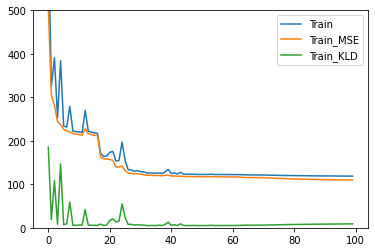

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_losses_MSE)
plt.plot(train_losses_KLD)
plt.legend(['Train', 'Train_MSE', 'Train_KLD'])
plt.ylim([0,500])

(0.0, 500.0)

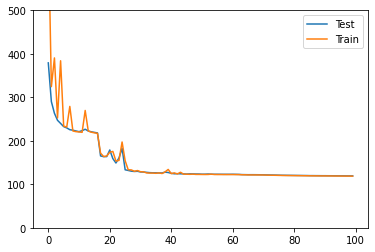

In [14]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])
plt.ylim([0,500])

In [15]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': (train_losses, test_losses),
    }, "/content/drive/MyDrive/TP2/Network/VAE/vae_100epoch.pt")

### Draw random samples form latent space and generate new data

In [16]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        break

In [17]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

df = preprocessor.decodeOutput(pred)
df[0]

,amount,unit,ingredient
0,0.046789646,teaspoon,flour
1,0.007748604,teaspoon,sugar
2,1.7422438,teaspoon,baking_powder
3,0.06824732,centimetre,</s>
4,0.06556511,centimetre,eggs
5,0.068843365,centimetre,flour
6,0.08434057,centimetre,flour
7,0.97095966,tablespoon,baking_soda
8,0.035762787,tablespoon,salt
9,0.0834465,teaspoon,salt
